<a href="https://colab.research.google.com/github/rexian/ML/blob/main/agenticai/langgraph/chatbot_agency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
!pip install -U langgraph langsmith langchain_community
!pip install langchain-nvidia-ai-endpoints
!pip install duckduckgo_search
!pip install pyppeteer pygraphviz
!pip install nest_asyncio

In [ ]:
import getpass
import os
from langchain_nvidia_ai_endpoints import ChatNVIDIA

if not os.environ.get("NVIDIA_API_KEY"):
  os.environ["NVIDIA_API_KEY"] = getpass.getpass("Enter API key for NVIDIA AI Endpoints: ")
llm = ChatNVIDIA(model="meta/llama3-70b-instruct")

Enter API key for NVIDIA AI Endpoints: ··········


In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
search = DuckDuckGoSearchResults()
tools = [search]
llm_with_tools = llm.bind_tools(tools)

prompt = ChatPromptTemplate.from_messages([
     ("system", "You are a helpful chat bot."),
     ("placeholder", "{messages}"),
     ("user", "Remember, always be polite!"),
])

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


if "chatbot" not in graph_builder.nodes:
  graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=[search])
if "tools" not in graph_builder.nodes:
  graph_builder.add_node("tools", tool_node)

if "chatbot" not in graph_builder.edges and tools_condition not in graph_builder.branches:
  graph_builder.add_conditional_edges(
      "chatbot",
      tools_condition,
  )
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

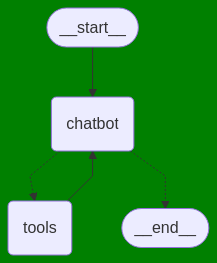

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
import nest_asyncio

nest_asyncio.apply()

try:
    display(Image(graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.API,
            background_color="green",
            padding=10,
        )))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
config = {"configurable": {"thread_id": 1}}
def stream_graph_updates(user_input: str):
    for s in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config=config, stream_mode="values"):
      message = s["messages"][-1]
      if isinstance(message, tuple):
         print(message)
      else:
         message.pretty_print()


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break